In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

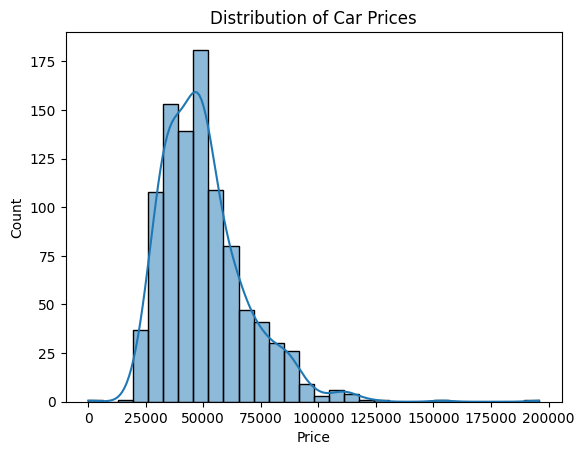

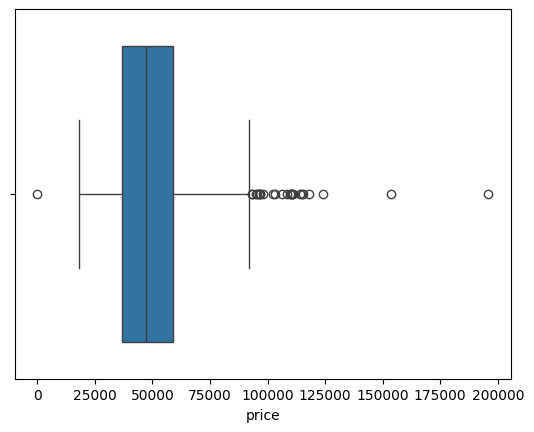

In [35]:
df = pd.read_csv('Vehicle.csv')
df.isnull().sum()

#data visualization
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()
sns.boxplot(x=df['price'])
plt.show()

In [36]:
#handling the missing value_numerical data
df['price'] =df['price'].fillna(df['price'].median())
df['mileage']=df['mileage'].fillna(df['mileage'].median())
#catagorical_data
df['description'] = df['description'].fillna(df['description'].mode()[0])
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].mode()[0])
df['fuel'] = df['fuel'].fillna(df['fuel'].mode()[0])
df['transmission'] = df['transmission'].fillna(df['transmission'].mode()[0])
df['trim'] = df['trim'].fillna(df['trim'].mode()[0])
df['body'] = df['body'].fillna(df['body'].mode()[0])
df['doors'] = df['doors'].fillna(df['doors'].mode()[0])
df['exterior_color'] = df['exterior_color'].fillna(df['exterior_color'].mode()[0])
df['interior_color'] = df['interior_color'].fillna(df['interior_color'].mode()[0])

In [37]:
#engine_missing value handling
invalid_values = ['o', ';', 'c', 'der', 'ER', 'oBoost', 'o ', 'c ', 'oZEV', 'c ZEV',
                  'o ZEV', 'ZEV', 'o Z', 'oZ', 'd>\n\n    \n    <dt>VIN', '<dt>VIN']
df['engine'] = df['engine'].replace(invalid_values, np.nan)


df['engine'] = df['engine'].apply(lambda x: np.nan if isinstance(x, str)
 and '<dt>VIN' in x else x)

engine_mode = df['engine'].mode()[0]
df['engine'] = df['engine'].fillna(engine_mode)


df = df.drop(['description', 'VIN', 'image_url', 'id'], axis=1, errors='ignore')

df = pd.get_dummies(df, drop_first=True)

df['price_log'] = np.log1p(df['price'])

In [38]:
#MODEL TRAINING
X = df.drop(['price', 'price_log'], axis=1)
y = df['price_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [39]:
#prediction and inverse transformation

y_pred_log = lr_model.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)

In [40]:
#getting the actual value from the  log
y_pred_log = lr_model.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)

y_test_actual = np.expm1(y_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)))
print("R² Score:", r2_score(y_test_actual, y_pred_actual))

RMSE: 7653.48469584234
R² Score: 0.7702031732211481


In [41]:
#random_forest for compareason

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf_log = rf_model.predict(X_test)
y_pred_rf_actual = np.expm1(y_pred_rf_log)

print("RF RMSE:", np.sqrt(mean_squared_error(y_test_actual, y_pred_rf_actual)))
print("RF R² Score:", r2_score(y_test_actual, y_pred_rf_actual))

RF RMSE: 7421.23970315899
RF R² Score: 0.7839379413243849


In [42]:
#xgboost for the compareason

# Split the data (if not already done)
X = df.drop('price', axis=1)
y = df['price']

# Clean column names for XGBoost
X.columns = X.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [43]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)


In [44]:
print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R² Score:", r2_xgb)

#cross check for the data_leaking or overfitting
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print("Cross-validation R² scores:", scores)
print("Average R² score:", scores.mean())


XGBoost RMSE: 406.80510875387256
XGBoost R² Score: 0.9993507702872456
Cross-validation R² scores: [0.99180875 0.97830299 0.99835217 0.99946279 0.91758402]
Average R² score: 0.9771021437080446
